**Project -- Wrangle and Analyze Data**

The "We Rate Dogs" Twitter archive contains over 5000 tweets, which have been filtered to create the enhanced archive that forms the basis of this analysis. The goal of this project is to wrangle the data - gather, assess, and clean - into a tidy dataset, and then provide analyses and visualizations.

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import requests
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")

# set the option to display the full string from a pandas DataFrame
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

**Gathering Data**

In [229]:
#load twitter archive data in a data frame
df_twitter = pd.read_csv('twitter-archive-enhanced.csv')

Programmatically Downloading, 'image-predictions.tsv' file

In [4]:
#Programmatically downloading file
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open('image-predictions.tsv', 'wb') as file:
    file.write(response.content)

# Retrieve HTTP meta-data
print(response.status_code)
print(response.headers['content-type'])
print(response.encoding)

200
text/tab-separated-values; charset=utf-8
utf-8


In [13]:
#converting into data frame
df_image = pd.read_csv('image-predictions.tsv','\t')

Quering the Twitter API to get each tweet's json data

In [5]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'ckFae6OxCl7cFfTnnnxbd0w05'
consumer_secret = 'mgYRN2UqCqkd7Alxn3RFj76CPuUHSVNVsfhfS24j1Yob1WCWE6'
access_token = '799957316401434625-kHcEV6BcceC8po3vnsGKSW8gQcJSpAi'
access_secret = 'XkTLCUQl1hH9KrRFf451JWdfUOSIc5ir7aGSyFXkLK63W'

In [6]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [7]:
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_twitter.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

**Convert JSON Data to DataFrame**

In [8]:

# Converting relevant JSON data to dataframe

tweets_list =[]

with open('tweet_json.txt') as json_file:
    for line in json_file:
    
        tweets_dict = {}
        tweets_json = json.loads(line)
        
        try:
            tweets_dict['tweet_id'] = tweets_json['extended_entities']['media'][0]['id']
        except:
            tweets_dict['tweet_id'] = 'na'

        tweets_dict['retweet_count'] = tweets_json['retweet_count']
        tweets_dict['favorite_count'] = tweets_json['favorite_count']
        
        tweets_list.append(tweets_dict)

In [9]:
tweets_df = pd.DataFrame(tweets_list)

**Accessing Data**

**1. Twitter Archive Data**

In [203]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

**It tells us the following:**
- 181 retweets (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)
- 78 replies (in_reply_to_status_id, in_reply_to_user_id)
- Timestamp field is in string format (object)
- Columns related to retweets are not applicable for original tweets
- Columns related to replies are not applicable for original tweets

In [204]:
str(type(df_twitter.timestamp[0]))

"<class 'str'>"

In [205]:
sum(df_twitter.duplicated())

0

In [18]:
df_twitter.head(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

In [17]:
df_twitter.tail(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2336,666273097616637952,NaN,NaN,2015-11-16 15:14:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Can take selfies 11/10 https://t.co/ws2AMaNwPW,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666273097616637952/photo/1,11,10,None,None,None,None,None
2337,666268910803644416,NaN,NaN,2015-11-16 14:57:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Very concerned about fellow dog trapped in computer. 10/10 https://t.co/0yxApIikpk,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666268910803644416/photo/1,10,10,None,None,None,None,None
2338,666104133288665088,NaN,NaN,2015-11-16 04:02:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666104133288665088/photo/1,1,10,None,None,None,None,None
2339,666102155909144576,NaN,NaN,2015-11-16 03:55:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Oh my. Here you are seeing an Adobe Setter giving birth to twins!!! The world is an amazing place. 11/10 https://t.co/11LvqN4WLq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666102155909144576/photo/1,11,10,None,None,None,None,None
2340,666099513787052032,NaN,NaN,2015-11-16 03:44:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Can stand on stump for what seems like a while. Built that birdhouse? Impressive. Made friends with a squirrel. 8/10 https://t.co/Ri4nMTLq5C,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666099513787052032/photo/1,8,10,None,None,None,None,None
2341,666094000022159362,NaN,NaN,2015-11-16 03:22:39 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This appears to be a Mongolian Presbyterian mix. Very tired. Tongue slip confirmed. 9/10 would lie down with https://t.co/mnioXo3IfP,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666094000022159362/photo/1,9,10,None,None,None,None,None
2342,666082916733198337,NaN,NaN,2015-11-16 02:38:37 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a well-established sunblockerspaniel. Lost his other flip-flop. 6/10 not very waterproof https://t.co/3RU6x0vHB7,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666082916733198337/photo/1,6,10,None,None,None,None,None
2343,666073100786774016,NaN,NaN,2015-11-16 01:59:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Let's hope this flight isn't Malaysian (lol). What a dog! Almost completely camouflaged. 10/10 I trust this pilot https://t.co/Yk6GHE9tOY,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666073100786774016/photo/1,10,10,None,None,None,None,None
2344,666071193221509120,NaN,NaN,2015-11-16 01:52:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a northern speckled Rhododendron. Much sass. Gives 0 fucks. Good tongue. 9/10 would caress sensually https://t.co/ZoL8kq2XFx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666071193221509120/photo/1,9,10,None,None,None,None,None
2345,666063827256086533,NaN,NaN,2015-11-16 01:22:45 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is the happiest dog you will ever see. Very committed owner. Nice couch. 10/10 https://t.co/RhUEAloehK,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666063827256086533/photo/1,10,10,the,None,None,None,None


In [206]:
df_twitter.isnull().sum()

tweet_id                      0   
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                     0   
source                        0   
text                          0   
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                 59  
rating_numerator              0   
rating_denominator            0   
name                          0   
doggo                         0   
floofer                       0   
pupper                        0   
puppo                         0   
dtype: int64


**Observations:**

The head() and tail() methods show several issues:

Quality:
- Some of the rows from the tail() output above have invalid strings in the name column, e.g. "a", "an", "in". These words are all the 3rd word in the tweet.
- Values of "None" in the name column.

Tidiness:

- The columns with numerical data that are typically used for analysis are located to the far right of the table, and the columns with long strings are on the left; this makes it difficult to readily see the data that will be used for analyses.

In [207]:
#checking value counts of name column
df_twitter.name.value_counts().head(50)

None        745
a           55 
Charlie     12 
Oliver      11 
Lucy        11 
Cooper      11 
Tucker      10 
Penny       10 
Lola        10 
Bo          9  
Winston     9  
the         8  
Sadie       8  
Buddy       7  
an          7  
Daisy       7  
Bailey      7  
Toby        7  
Dave        6  
Oscar       6  
Bella       6  
Jax         6  
Leo         6  
Stanley     6  
Scout       6  
Rusty       6  
Koda        6  
Milo        6  
Jack        6  
George      5  
Phil        5  
Sammy       5  
Gus         5  
Larry       5  
Louis       5  
Oakley      5  
very        5  
Bentley     5  
Alfie       5  
Sunny       5  
Chester     5  
Finn        5  
Boomer      4  
Scooter     4  
Gary        4  
Reginald    4  
Cassie      4  
Jerry       4  
Clarence    4  
Maximus     4  
Name: name, dtype: int64

In [208]:
#Words that beign with lower case are not names
# list all names that are NOT capitalized
not_names = df_twitter.name.str.contains('^[a-z]', regex = True)
df_twitter[not_names].name.value_counts().sort_index()

a               55
actually        2 
all             1 
an              7 
by              1 
getting         2 
his             1 
incredibly      1 
infuriating     1 
just            4 
life            1 
light           1 
mad             2 
my              1 
not             2 
officially      1 
old             1 
one             4 
quite           4 
space           1 
such            1 
the             8 
this            1 
unacceptable    1 
very            5 
Name: name, dtype: int64

In [209]:
#checking value counts of ratig denominator
df_twitter.rating_denominator.value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [210]:
#denominator should be 10
#checking numerator ratings
df_twitter.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

In [211]:
#checking other value counts

print(df_twitter.doggo.value_counts())
print()
print(df_twitter.floofer.value_counts())
print()
print(df_twitter.pupper.value_counts())
print()
print(df_twitter.puppo.value_counts())

None     2259
doggo    97  
Name: doggo, dtype: int64

None       2346
floofer    10  
Name: floofer, dtype: int64

None      2099
pupper    257 
Name: pupper, dtype: int64

None     2326
puppo    30  
Name: puppo, dtype: int64


In [212]:
#number of retweets
df_twitter.retweeted_status_id.notnull().sum()

181

In [213]:
#number of replies
df_twitter.in_reply_to_status_id.notnull().sum()

78

In [214]:
# Section containing retweet and replies
df_twitter[185:190]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Jenna_Marbles: @dog_rates Thanks for rating my cermets 14/10 wow I'm so proud I watered them so much,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,279280991.0,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
187,856282028240666624,NaN,NaN,2017-04-23 23:01:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Cermet, Paesh, and Morple. They are absolute h*ckin superstars. Watered every day so they can grow. 14/10 for all https://t.co/GUefqUmZv8",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/856282028240666624/photo/1,https://twitter.com/dog_rates/status/856282028240666624/photo/1,https://twitter.com/dog_rates/status/856282028240666624/photo/1,https://twitter.com/dog_rates/status/856282028240666624/photo/1",14,10,Cermet,None,None,None,None
188,855862651834028034,8.558616e+17,194351775.0,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,13615722.0,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [215]:
df_twitter.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64


**More Observations:**

Quality:

- There are 23 cases where the denominator of rating != 10. These entries will be removed.
- Rename columns with more appropriate names: "timestamp" to "tweet_timestamp", "text" to "tweet_text", "rating_numerator" to "dog_rating_out_of_ten", "name" to "dog_name"
- Since retweets and replies will be removed, the column "retweeted_status_timestamp" will be removed as it will no longer provide any useful information.
- Remove column "rating_denominator" once all the values that != 10 have been removed since this will no longer provide any useful information.


Tidiness:
- Change columns "doggo", "floofer", "pupper", and "puppo" from wide to long format.

**2. Image Prediction Data**

In [216]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [217]:
df_image.head(15)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [218]:
df_image.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [219]:
df_image.p1_dog.value_counts()

True     1532
False    543 
Name: p1_dog, dtype: int64

**Assessments for quality:**

- Entries where the first (i.e. most confident prediction) has a False value for "p1_dog" can be removed.

- The "p1" and "p1_conf" columns will be renamed with more explanatory titles.

- The column "jpg_url" will be removed since url data is already contained in the twitter archive data

- The "p2" and "p3" related columns will be removed as using the most likely prediction ("p1") in analysis

- After removal of "False" entries, the "p1_dog" column will be removed as it will no longer add any valuable information.

**Retweet, Favourite Count Data**

In [220]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
favorite_count    2331 non-null int64
retweet_count     2331 non-null int64
tweet_id          2331 non-null object
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


In [221]:
tweets_df.head()

,favorite_count,retweet_count,tweet_id
0,36275,7724,892420639486877696
1,31279,5709,892177413194625024
2,23546,3783,891815175371796480
3,39568,7877,891689552724799489
4,37790,8495,891327551943041024


In [222]:
tweets_df.favorite_count.describe()

count    2331.000000  
mean     7575.220935  
std      11757.043073 
min      0.000000     
25%      1320.500000  
50%      3296.000000  
75%      9275.000000  
max      156487.000000
Name: favorite_count, dtype: float64

In [223]:
tweets_df.retweet_count.describe()

count    2331.000000 
mean     2709.168168 
std      4581.685256 
min      1.000000    
25%      548.000000  
50%      1270.000000 
75%      3148.000000 
max      77970.000000
Name: retweet_count, dtype: float64

In [224]:
tweets_df.isnull().sum()

favorite_count    0
retweet_count     0
tweet_id          0
dtype: int64

**Assessments for quality and tidiness:**
- After trying to merge the data, it appears that there is some non-numeric values for the "tweet_id" inputs which will need to be removed.

**Cleaning Data**

**1. Twitter Archive Data**

In [230]:
df_twitter_clean = df_twitter.copy()
len_clean = df_twitter_clean.shape[0]
len_clean

2356

**Quality Issues**

**There are 181 retweets and we are interested in original tweets**

**Define**
- Drop all rows containing retweets, where these columns will be non-null: retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp.


**Code**

In [231]:
sum(df_twitter_clean.retweeted_status_id.notnull())

181

In [232]:
df_twitter_clean = df_twitter_clean[df_twitter_clean.retweeted_status_id.isna()]

**Test**

In [233]:
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

In [234]:
# confirm the rows are dropped; compare with original table length
print(len_clean - df_twitter_clean.shape[0])
#resetting length
len_clean = df_twitter_clean.shape[0]

181


2. There are 78 reply tweets; we’re only interested in “original tweets”.

**Define**
- Drop all rows that are replies, those that have non-null values in these columns: in_reply_to_status_id and in_reply_to_user_id.

**Code**

In [235]:
sum(df_twitter_clean.in_reply_to_status_id.notnull())

78

In [236]:
df_twitter_clean = df_twitter_clean[df_twitter_clean.in_reply_to_status_id.isna()]

**Test**

In [237]:
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

In [238]:
# confirm the rows are dropped; compare with previous table length
print(len_clean - df_twitter_clean.shape[0])
#resetting lenght\
len_clean = df_twitter_clean.shape[0]

78


**Tidiness Issues**

All columns related to “retweets” will be empty (we're not interested in retweets).

**Define**
- Since we don't want retweets, we can drop all columns related to retweets: retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp.

**Code**

In [239]:
df_twitter_clean = df_twitter_clean.drop(['retweeted_status_id',
                                    'retweeted_status_user_id',
                                    'retweeted_status_timestamp'], axis = 1)

**Test**

In [240]:
# Confirm all retweet related columns are deleted
list(df_twitter_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

- All columns related to “replies” will be empty (we're not interested in replies).

**Define**
- Drop all columns related to replies: in_reply_to_status_id and in_reply_to_user_id.

**Code**

In [241]:
df_twitter_clean = df_twitter_clean.drop(['in_reply_to_status_id',
                                    'in_reply_to_user_id'], axis = 1)

**Test**

In [242]:
# Confirm all reply related columns are deleted
list(df_twitter_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

**Quality Issue**
3. The timestamp column is in string format, it's the wrong data type.

**Define**
- Convert timestamp to datetime data type.

**Code**

In [243]:
df_twitter_clean['timestamp'] = pd.to_datetime(df_twitter_clean.timestamp)
df_twitter_clean['timestamp'] = df_twitter_clean.timestamp.dt.floor('s')

**Test**

In [244]:
df_twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 213.0+ KB


**More Quality Issues**

**Define**
- Removing multiple cases of where the denominator of rating != 10.

**Code**

In [245]:
df_twitter_clean.drop(df_twitter_clean[df_twitter_clean.rating_denominator != 10].index, inplace = True)

**Test**

In [246]:
df_twitter_clean.rating_denominator.value_counts()

10    2080
Name: rating_denominator, dtype: int64

**Define**

- Rename columns with more appropriate names: "timestamp" to "tweet_timestamp", "text" to "tweet_text", "rating_numerator" to "dog_rating_out_of_ten", "name" to "dog_name"

**Code**

In [247]:
new_names = {'timestamp': 'tweet_timestamp', 'text': 'tweet_text',\
             'rating_numerator': 'dog_rating_out_of_ten', 'name': 'dog_name'}


df_twitter_clean.rename(columns=new_names, inplace=True)

**Test**

In [248]:
list(df_twitter_clean.columns)

['tweet_id',
 'tweet_timestamp',
 'source',
 'tweet_text',
 'expanded_urls',
 'dog_rating_out_of_ten',
 'rating_denominator',
 'dog_name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

**Define**
- Removing column rating_denominator

**Code**

In [249]:
drop_cols = ['rating_denominator']


df_twitter_clean.drop(drop_cols, inplace=True, axis=1)

**Test**

In [250]:
list(df_twitter_clean.columns)

['tweet_id',
 'tweet_timestamp',
 'source',
 'tweet_text',
 'expanded_urls',
 'dog_rating_out_of_ten',
 'dog_name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

**Tidiness Issue**
**Define**
- Change columns "doggo", "floofer", "pupper", and "puppo" from wide to long format.

**Code**

In [251]:
df_twitter_clean = df_twitter_clean.reset_index()
del df_twitter_clean['index']

In [252]:
df_twitter_clean['dog_category'] = 'NaN'

In [253]:

# Creating a single column for dog category

for i in range(0, len(df_twitter_clean.index)):
    if df_twitter_clean.loc[i, 'doggo'] == 'doggo':
        df_twitter_clean.loc[i, 'dog_category'] = 'doggo'
    elif df_twitter_clean.loc[i, 'floofer'] == 'floofer':
         df_twitter_clean.loc[i, 'dog_category'] = 'floofer'
    elif df_twitter_clean.loc[i, 'pupper'] == 'pupper':
         df_twitter_clean.loc[i, 'dog_category'] = 'pupper'
    elif df_twitter_clean.loc[i, 'puppo'] == 'puppo':
        df_twitter_clean.loc[i, 'dog_category'] = 'puppo'
    else:
        df_twitter_clean.loc[i, 'dog_category'] = 'None'

In [254]:
# Checking for entries labelled with multiple categories

multi_cat_list = []

for i in range(0, len(df_twitter_clean.index)):
    if df_twitter_clean.doggo[i] == 'doggo' and (df_twitter_clean.floofer[i] == 'floofer' \
                                                   or df_twitter_clean.pupper[i] == 'pupper'\
                                                   or df_twitter_clean.puppo[i] == 'puppo'):
        multi_cat_list.append(i)

print(multi_cat_list)
print(len(multi_cat_list))

[154, 161, 357, 414, 444, 534, 560, 687, 745, 845, 893]
11


In [255]:
# 10 cases of multiple categories found 
# Checking text of entry to correct category to correct values
# Index 153    
df_twitter_clean.loc[153, ['doggo', 'floofer', 'pupper', 'puppo', 'dog_category']]

doggo           None
floofer         None
pupper          None
puppo           None
dog_category    None
Name: 153, dtype: object

In [256]:
df_twitter_clean.tweet_text[153]

'HE\'S LIKE "WAIT A MINUTE I\'M AN ANIMAL THIS IS AMAZING HI HUMAN I LOVE YOU AS WELL" 13/10 https://t.co/sb73bV5Y7S'

In [257]:
#It is a puppo but wrongly defined as a doggo
df_twitter_clean.loc[153, 'dog_category'] = 'puppo'

In [258]:
# Index 160
df_twitter_clean.loc[160, ['doggo', 'floofer', 'pupper', 'puppo', 'dog_category']]

doggo           None  
floofer         None  
pupper          pupper
puppo           None  
dog_category    pupper
Name: 160, dtype: object

In [259]:
df_twitter_clean.tweet_text[160]

'Sometimes you guys remind me just how impactful a pupper can be. Cooper will be remembered as a good boy by so many. 14/10 rest easy friend https://t.co/oBL7LEJEzR'

In [260]:
#it is a floofer
df_twitter_clean.loc[160, 'dog_category'] = 'floofer'

In [261]:
# Index 354
df_twitter_clean.loc[354, ['doggo', 'floofer', 'pupper', 'puppo', 'dog_category']]

doggo           None
floofer         None
pupper          None
puppo           None
dog_category    None
Name: 354, dtype: object

In [262]:
df_twitter_clean.tweet_text[354]

'This is Autumn. Her favorite toy is a cheeseburger. She takes it everywhere. 11/10 https://t.co/JlPug12E5Z'

In [263]:
#it is a pupper
df_twitter_clean.loc[354, 'dog_category'] = 'pupper'

In [264]:
# Index 411 
df_twitter_clean.loc[411, ['doggo', 'floofer', 'pupper', 'puppo', 'dog_category']]

doggo           None  
floofer         None  
pupper          pupper
puppo           None  
dog_category    pupper
Name: 411, dtype: object

In [265]:
df_twitter_clean.tweet_text[411]

"Here's a pupper in a onesie. Quite pupset about it. Currently plotting revenge. 12/10 would rescue https://t.co/xQfrbNK3HD"

In [266]:
# multiple dogs/categories present: "multiple"
df_twitter_clean.loc[411, 'dog_category'] = 'multiple'

In [267]:

# Index 441 
df_twitter_clean.loc[441, ['doggo', 'floofer', 'pupper', 'puppo', 'dog_category']]

doggo           None
floofer         None
pupper          None
puppo           None
dog_category    None
Name: 441, dtype: object

In [268]:
df_twitter_clean.tweet_text[441]

"This is Wallace. He'll be your chau-fur this evening. 12/10 eyes on the road Wallace https://t.co/p1RD39XjUe"

In [269]:
#it is a pupper
df_twitter_clean.loc[441, 'dog_category'] = 'pupper'

In [270]:

# Index 531
df_twitter_clean.loc[531, ['doggo', 'floofer', 'pupper', 'puppo', 'dog_category']]

doggo           None
floofer         None
pupper          None
puppo           None
dog_category    None
Name: 531, dtype: object

In [271]:
df_twitter_clean.tweet_text[531]

"This is Mattie. She's extremely dangerous. Will bite your h*ckin finger right off. Still 11/10 would pet with caution https://t.co/78c9W8kLFh"

In [272]:
#already correct

In [273]:
# Index 556 
df_twitter_clean.loc[556, ['doggo', 'floofer', 'pupper', 'puppo', 'dog_category']]

doggo           None
floofer         None
pupper          None
puppo           None
dog_category    None
Name: 556, dtype: object

In [274]:
df_twitter_clean.tweet_text[556]

'This is Chipson. He weighed in at .3 ounces and is officially super h*ckin smol. Space-saving af. 11/10 would snug delicately https://t.co/FjEsk7A1JV'

In [275]:
# Correcting to "multiple"
df_twitter_clean.loc[556, 'dog_category'] = 'multiple'

In [276]:

# Index 677
df_twitter_clean.loc[677, ['doggo', 'floofer', 'pupper', 'puppo', 'dog_category']]

doggo           None
floofer         None
pupper          None
puppo           None
dog_category    None
Name: 677, dtype: object

In [277]:
df_twitter_clean.tweet_text[677]

'This is Rose. Her face is stuck like that. 11/10 would pet so heckin well https://t.co/tl3gNYdoq2'

In [101]:
# Correcting to "multiple"
df_twitter_clean.loc[677, 'dog_category'] = 'multiple'

In [278]:
# Index 813
df_twitter_clean.loc[813, ['doggo', 'floofer', 'pupper', 'puppo', 'dog_category']]

doggo           doggo
floofer         None 
pupper          None 
puppo           None 
dog_category    doggo
Name: 813, dtype: object

In [279]:
df_twitter_clean.tweet_text[813]

"This is Lenox. She's in a wheelbarrow. Silly doggo. You don't belong there. 10/10 would push around https://t.co/oYbVR4nBsR"

In [280]:
# Correcting to "multiple"
df_twitter_clean.loc[813, 'dog_category'] = 'multiple'

In [281]:
# Index 852
df_twitter_clean.loc[852, ['doggo', 'floofer', 'pupper', 'puppo', 'dog_category']]

doggo           None
floofer         None
pupper          None
puppo           None
dog_category    None
Name: 852, dtype: object

In [282]:
df_twitter_clean.tweet_text[852]

'This is getting incredibly frustrating. This is a Mexican Golden Beaver. We only rate dogs. Only send dogs ...10/10 https://t.co/0yolOOyD3X'

In [283]:
# Correcting to "multiple"
df_twitter_clean.loc[852, 'dog_category'] = 'multiple'

In [284]:

# dropping original dog category columns

# Test
drop_cols = ['doggo', 'floofer', 'pupper', 'puppo']
df_twitter_clean.drop(drop_cols, axis=1, inplace=True)
df_twitter_clean.head()

,tweet_id,tweet_timestamp,source,tweet_text,expanded_urls,dog_rating_out_of_ten,dog_name,dog_category
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,Phineas,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,Tilly,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,Archie,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,Darla,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,Franklin,None


**Quality Issue**
**Define**
- There are many tweets with regular words in the name column that are NOT a valid name.
- Replace all lowercase words in the name column with the string "none".

**Code**

In [285]:
names_invalid = df_twitter_clean.dog_name.str.contains('^[a-z]', regex = True)
df_twitter_clean[names_invalid].dog_name.value_counts().sort_index()

a               54
actually        2 
all             1 
an              5 
by              1 
getting         2 
his             1 
incredibly      1 
infuriating     1 
just            3 
life            1 
light           1 
mad             1 
my              1 
not             2 
officially      1 
old             1 
one             4 
quite           3 
space           1 
such            1 
the             8 
unacceptable    1 
very            4 
Name: dog_name, dtype: int64

In [286]:
df_twitter_clean.loc[names_invalid, 'dog_name'] = "none"

**Test**

In [287]:
#All the entries were changed to "none"
df_twitter_clean[names_invalid].dog_name.value_counts().sort_index()

none    101
Name: dog_name, dtype: int64

**2 Image Prediction Data**

In [288]:
#make copy
df_image_clean = df_image.copy()

**Quality Issues**
**Define**
- Entries where the first (i.e. most confident prediction) has a False value for "p1_dog" can be removed.

**Code**

In [289]:
df_image_clean.drop(df_image_clean[df_image_clean.p1_dog == False].index, inplace=True)

**Test**

In [290]:
df_image_clean.p1_dog.value_counts()

True    1532
Name: p1_dog, dtype: int64

**Define**
- The "p1" and "p1_conf" columns will be renamed with more explanatory titles.

**Code**

In [291]:
new_names = {'p1':'dog_category_prediction', 'p1_conf':'prediction_confidence'}

df_image_clean.rename(columns= new_names, inplace=True)

**Test**

In [292]:
list(df_image_clean.columns)

['tweet_id',
 'jpg_url',
 'img_num',
 'dog_category_prediction',
 'prediction_confidence',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

**Define**
- The column "jpg_url" will be removed since url data is already contained in the twitter archive data

- The "p2" and "p3" related columns will be removed as using the most likely prediction ("p1") in analysis

- After removal of "False" entries, the "p1_dog" column will be removed as it will no longer add any valuable information.

**Code**

In [293]:
drop_cols = ['jpg_url', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p2_conf', 'p3_dog', 'p3_conf']

df_image_clean.drop(drop_cols, inplace=True, axis=1)

**Test**

In [294]:
list(df_image_clean.columns)

['tweet_id', 'img_num', 'dog_category_prediction', 'prediction_confidence']

**3 Retweet, Favourite Count Data**

In [295]:
#make a copy
tweets_df_clean = tweets_df.copy()

**Define**
- Finding non-numeric values for "tweet_id"

**Code**

In [296]:
index_list = []

for i in range(0, len(tweets_df_clean.tweet_id)):
    if type(tweets_df_clean.tweet_id[i]) != int:
        index_list.append(i)

In [297]:
print(len(index_list))
#print(nn_index_list)

272


In [298]:
tweets_df_clean.shape

(2331, 3)

In [299]:
for i in index_list:
    tweets_df_clean.drop(tweets_df_clean[tweets_df_clean.index == i].index, inplace=True)

**Test**

In [300]:
tweets_df_clean.shape

(2059, 3)

In [301]:
# Reset index
tweets_df_clean = tweets_df_clean.reset_index()
del tweets_df_clean['index']

**Another Tidiness Issue in twitter archive data**
- Reorder the column placement: bring numerical columns to the left.

In [302]:
list(df_twitter_clean.columns)

['tweet_id',
 'tweet_timestamp',
 'source',
 'tweet_text',
 'expanded_urls',
 'dog_rating_out_of_ten',
 'dog_name',
 'dog_category']

In [303]:
# set the columns in a new order
col_list = ['tweet_id', 'tweet_timestamp', 'dog_rating_out_of_ten',
            'dog_category', 'dog_name', 'source', 'tweet_text','expanded_urls']

df_twitter_clean = df_twitter_clean[col_list]

**Test**

In [304]:
df_twitter_clean.head()

,tweet_id,tweet_timestamp,dog_rating_out_of_ten,dog_category,dog_name,source,tweet_text,expanded_urls
0,892420643555336193,2017-08-01 16:23:56,13,None,Phineas,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1
1,892177421306343426,2017-08-01 00:17:27,13,None,Tilly,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1
2,891815181378084864,2017-07-31 00:18:03,12,None,Archie,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1
3,891689557279858688,2017-07-30 15:58:51,13,None,Darla,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1
4,891327558926688256,2017-07-29 16:00:24,12,None,Franklin,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1"


**Combining Data**
- Combining the three dataframes into one before analysing

In [305]:
master_df = pd.merge(df_twitter_clean, df_image_clean, on='tweet_id', how='left')

In [306]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2079
Data columns (total 11 columns):
tweet_id                   2080 non-null int64
tweet_timestamp            2080 non-null datetime64[ns]
dog_rating_out_of_ten      2080 non-null int64
dog_category               2080 non-null object
dog_name                   2080 non-null object
source                     2080 non-null object
tweet_text                 2080 non-null object
expanded_urls              2077 non-null object
img_num                    1449 non-null float64
dog_category_prediction    1449 non-null object
prediction_confidence      1449 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 195.0+ KB


In [307]:
tweets_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 3 columns):
favorite_count    2059 non-null int64
retweet_count     2059 non-null int64
tweet_id          2059 non-null object
dtypes: int64(2), object(1)
memory usage: 48.3+ KB


In [308]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2079
Data columns (total 11 columns):
tweet_id                   2080 non-null int64
tweet_timestamp            2080 non-null datetime64[ns]
dog_rating_out_of_ten      2080 non-null int64
dog_category               2080 non-null object
dog_name                   2080 non-null object
source                     2080 non-null object
tweet_text                 2080 non-null object
expanded_urls              2077 non-null object
img_num                    1449 non-null float64
dog_category_prediction    1449 non-null object
prediction_confidence      1449 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 195.0+ KB


In [309]:
tweets_df_clean['tweet_id']=tweets_df_clean['tweet_id'].astype(np.int64)
master_df['tweet_id']=master_df['tweet_id'].astype(np.int64)

tweets_df_clean['tweet_id']=tweets_df_clean['tweet_id'].astype(int)
master_df['tweet_id']=master_df['tweet_id'].astype(int)

In [310]:
master_df_final = pd.merge(master_df, tweets_df_clean,on=['tweet_id'],how='left')

**Saving Data to CSV**

In [311]:

master_df_final.to_csv('twitter_archive_master.csv')
df_twitter_clean.to_csv('clean_twitter_data.csv')
df_image_clean.to_csv('clean_image_prediction_data.csv')
tweets_df_clean.to_csv('clean_rt_and_fav_data.csv')

**Analysis**

**The analysis and visualizations will be based on the data that has been wrangled(gathered, assessed and cleaned) above**

**Insight 1**

In [314]:
master_df_final[['dog_rating_out_of_ten', 'retweet_count', 'favorite_count', 'prediction_confidence']].describe()

,dog_rating_out_of_ten,retweet_count,favorite_count,prediction_confidence
count,2080.000000,0.0,0.0,1449.000000
mean,11.698077,NaN,NaN,0.614341
std,39.816875,NaN,NaN,0.260345
min,0.000000,NaN,NaN,0.044333
25%,10.000000,NaN,NaN,0.392108
50%,11.000000,NaN,NaN,0.615163
75%,12.000000,NaN,NaN,0.852088
max,1776.000000,NaN,NaN,0.999956


In [315]:
# Percentage of tweets with rating of 10 and up
rating_10up = sum(master_df_final.dog_rating_out_of_ten >= 10)
rating_10up_per = round(rating_10up * 100 / master_df_final.shape[0])
print("Number of tweets with rating 10+:  {}".format(rating_10up))
print("Percentage of tweets:                {}%".format(round(rating_10up_per, 3)))

Number of tweets with rating 10+:  1665
Percentage of tweets:                80%


In [316]:
# How many tweets have favorite count <= retweet count?
sum(master_df_final.favorite_count <= master_df_final.retweet_count)

0

**Insight 2**
- Top 5 retweeted tweets and top 5 most favorite tweets

In [320]:
#most favorite top 5
master_df_final.sort_values(by = 'favorite_count', ascending = False).head(5)

,tweet_id,tweet_timestamp,dog_rating_out_of_ten,dog_category,dog_name,source,tweet_text,expanded_urls,img_num,dog_category_prediction,prediction_confidence,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56,13,None,Phineas,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,NaN,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27,13,None,Tilly,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,1.0,Chihuahua,0.323581,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03,12,None,Archie,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,1.0,Chihuahua,0.716012,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51,13,None,Darla,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,NaN,NaN,NaN,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24,12,None,Franklin,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",2.0,basset,0.555712,NaN,NaN


In [323]:
#most retweeted top 5
master_df_final.sort_values(by = 'retweet_count', ascending = False).head(5)

,tweet_id,tweet_timestamp,dog_rating_out_of_ten,dog_category,dog_name,source,tweet_text,expanded_urls,img_num,dog_category_prediction,prediction_confidence,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56,13,None,Phineas,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,NaN,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27,13,None,Tilly,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,1.0,Chihuahua,0.323581,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03,12,None,Archie,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,1.0,Chihuahua,0.716012,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51,13,None,Darla,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,NaN,NaN,NaN,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24,12,None,Franklin,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",2.0,basset,0.555712,NaN,NaN


In [326]:
master_df_final.dog_category.value_counts()

None        1739
pupper      221 
doggo       82  
puppo       24  
floofer     10  
multiple    4   
Name: dog_category, dtype: int64

**Insight 3**
- Most Common Dog Category

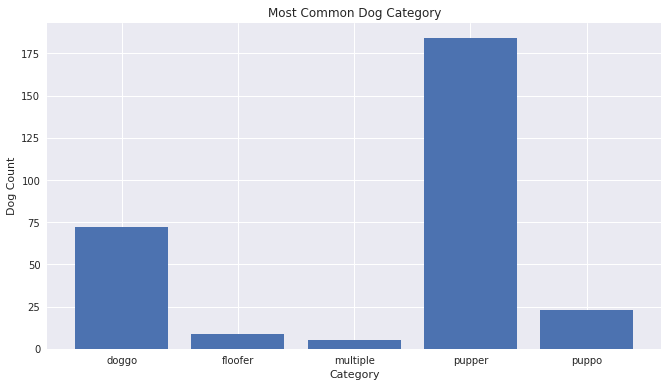

In [328]:
dog_type = ['pupper', 'doggo', 'puppo', 'floofer', 'multiple']
dog_counts = [184, 72, 23, 9, 5]

fig,ax = plt.subplots(figsize = (11,6))
ax.bar(dog_type, dog_counts, width = 0.8)
ax.set_ylabel('Dog Count')
ax.set_xlabel('Category')
plt.title("Most Common Dog Category")
plt.show()

In [329]:
#As we can see most common dog type is pupper

**More Insights**

In [334]:
master_df_final.dog_category_prediction.value_counts()

golden_retriever                  134
Labrador_retriever                91 
Pembroke                          88 
Chihuahua                         78 
pug                               54 
chow                              41 
Samoyed                           40 
Pomeranian                        38 
toy_poodle                        37 
malamute                          29 
cocker_spaniel                    27 
French_bulldog                    26 
Chesapeake_Bay_retriever          23 
miniature_pinscher                21 
German_shepherd                   20 
Staffordshire_bullterrier         19 
Siberian_husky                    19 
Eskimo_dog                        18 
Shetland_sheepdog                 18 
Shih-Tzu                          17 
Maltese_dog                       17 
beagle                            17 
Cardigan                          17 
Rottweiler                        16 
Italian_greyhound                 16 
Lakeland_terrier                  15 
kuvasz      

In [337]:
tweets_df_clean.retweet_count.describe()

count    2059.000000 
mean     2590.420593 
std      4524.548415 
min      11.000000   
25%      554.000000  
50%      1226.000000 
75%      2982.500000 
max      77970.000000
Name: retweet_count, dtype: float64

In [338]:
tweets_df_clean.favorite_count.describe()

count    2059.000000  
mean     7999.349199  
std      12081.884851 
min      0.000000     
25%      1524.000000  
50%      3529.000000  
75%      9980.000000  
max      156487.000000
Name: favorite_count, dtype: float64

In [339]:
master_df_final.dog_rating_out_of_ten.describe()

count    2080.000000
mean     11.698077  
std      39.816875  
min      0.000000   
25%      10.000000  
50%      11.000000  
75%      12.000000  
max      1776.000000
Name: dog_rating_out_of_ten, dtype: float64

**Other Insights**
- Most popular dig type is a pupper
- The most popular dog, based on image predictions, is a Golden Retriever
- The median and mean retweet count is 1226 and 2590.42 respectively
- The median and mean favorite count is 3529 and 7999.35 respectively
- The median and mean ratings out of ten are 11 and 11.69 respectively